## Import Library

In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error 
plt.style.use('fivethirtyeight')

## Import Data and do preprocessing
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

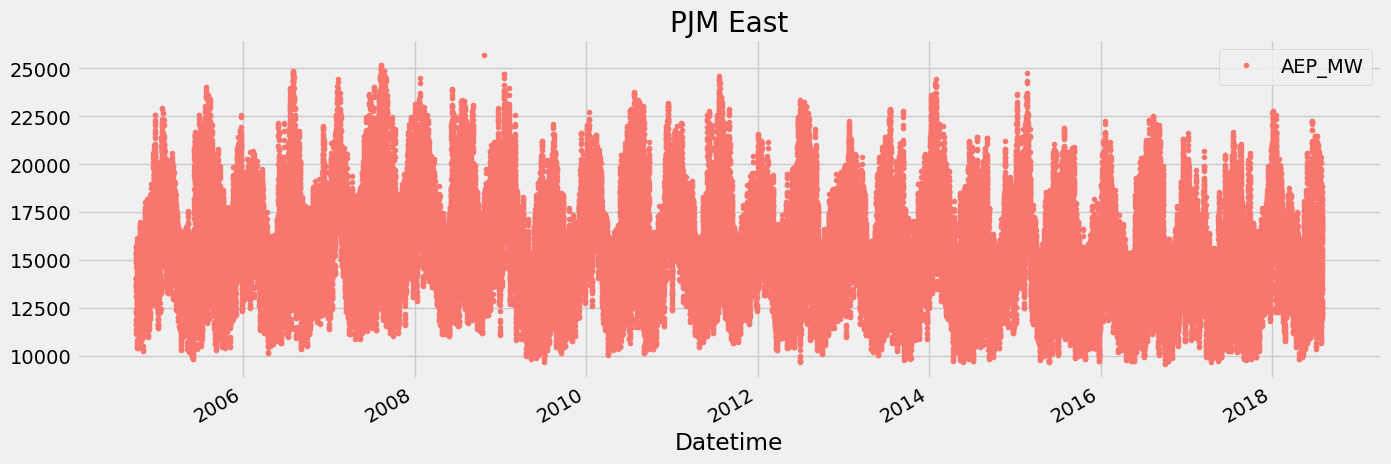

In [2]:
pjme = pd.read_csv('D:/[DOC]/MASH_/20250206/AEP_hourly.csv', index_col=[0], parse_dates=[0])
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [3]:
pjme.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


## Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [4]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

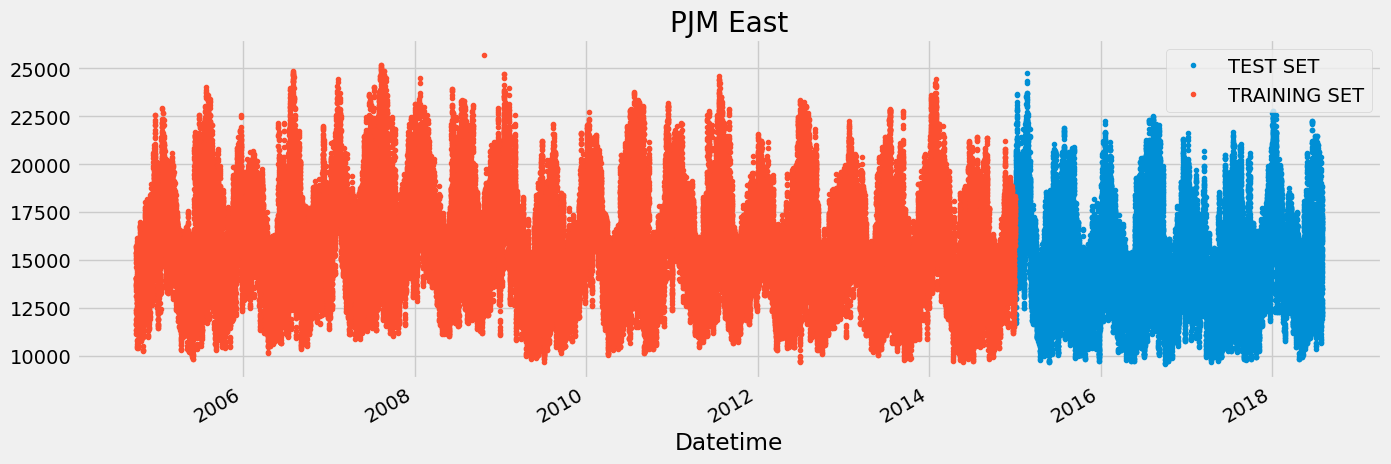

In [5]:
_ = pjme_test.rename(columns={'AEP_MW': 'TEST SET'}).join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='PJM East', style='.')

## Create Time Series Features

In [6]:
# X 为所有可用时间解释的变量(feature)；可只考虑较重要的特征维度，或采用降维后特征
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
##    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
# 对字符型变量{'hour','dayofweek','quarter','month'}做one-hot-encoding----以2D array
X_train, y_train = create_features(pjme_train, label='AEP_MW')
##X_train = pd.get_dummies(X_train_ori, columns=['hour','dayofweek','quarter','month'])
X_test, y_test = create_features(pjme_test, label='AEP_MW')
##X_test = pd.get_dummies(X_test_ori, columns=['hour','dayofweek','quarter','month'])

In [8]:
# 归一化
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# 将数据转换为LSTM需要的形状 [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [10]:
# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

D:\ProgramData\anaconda3\envs\py39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 训练模型
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=2, shuffle=False)

Epoch 1/100
1248/1248 - 9s - 7ms/step - loss: 253350192.0000 - val_loss: 223559216.0000
Epoch 2/100
1248/1248 - 3s - 2ms/step - loss: 251491584.0000 - val_loss: 222030976.0000
Epoch 3/100
1248/1248 - 3s - 2ms/step - loss: 249904256.0000 - val_loss: 220582544.0000
Epoch 4/100
1248/1248 - 3s - 2ms/step - loss: 248372352.0000 - val_loss: 219158960.0000
Epoch 5/100
1248/1248 - 3s - 2ms/step - loss: 246860944.0000 - val_loss: 217746848.0000
Epoch 6/100
1248/1248 - 3s - 2ms/step - loss: 245360016.0000 - val_loss: 216342000.0000
Epoch 7/100
1248/1248 - 3s - 2ms/step - loss: 243866704.0000 - val_loss: 214942816.0000
Epoch 8/100
1248/1248 - 3s - 3ms/step - loss: 242378544.0000 - val_loss: 213548400.0000
Epoch 9/100
1248/1248 - 3s - 2ms/step - loss: 240895984.0000 - val_loss: 212159280.0000
Epoch 10/100
1248/1248 - 3s - 2ms/step - loss: 239418480.0000 - val_loss: 210774784.0000
Epoch 11/100
1248/1248 - 3s - 2ms/step - loss: 237945584.0000 - val_loss: 209395056.0000
Epoch 12/100
1248/1248 - 3s - 

## Forecast on Test Set

In [12]:
# 预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2808/2808 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step


In [13]:
test_predict

array([[4844.8667],
       [4844.8667],
       [4844.8667],
       ...,
       [4844.8667],
       [4844.8667],
       [4844.8667]], dtype=float32)

In [14]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

NameError: name 'reg' is not defined

In [ ]:
_ = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

## Look at first month of predictions

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Error Metrics On Test Set
Our RMSE error is ?

Our MAE error is ?

Our MAPE error is ?

In [ ]:
mean_squared_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

In [ ]:
mean_absolute_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

## Look at Worst and Best Predicted Days

In [ ]:
pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[['AEP_MW','MW_Prediction','error','abs_error']]

In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Notice anything about the over forecasted days?

<li> worst day - July 4th, 2016 - is a holiday. </li>
<li> worst day - December 25, 2015 - Christmas. </li>
<li> worst day - July 4th, 2016 - is a holiday. </li>
Looks like our model may benefit from adding a holiday indicator.

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

The best predicted days seem to be a lot of Dec. (not many holidays and mild weather) Also early may

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Plotting some best/worst predicted days

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Up next?
<li>Add Lag variables.</li>
<li>Add holiday indicators.</li>
<li>Add weather data source.</li>
<li>Add other data source empirically correlated to time.</li>